In [128]:
import pandas as pd
import numpy as np

In [129]:
df = pd.read_csv('results.csv')

In [130]:
#df = df.dropna(axis = 0)
df['date'] =  pd.to_datetime(df['date'], format='%Y-%m-%d')

cutoff = pd.to_datetime(1972, format='%Y')

df = df[df['date']>cutoff]
df = df.reset_index(drop=True)

In [131]:
tourn_dict = {'Friendly':20,
             'FIFA World Cup':60,
             'AFC Asian Cup': 50,
             'African Cup of Nations':50,
             'African Nations Championship':50,
             'Gold Cup': 50,
             'CONCACAF Nations League': 50,
             'Copa América': 50,
             'Oceania Nations Cup': 50,
             'UEFA Euro': 50,
             'UEFA Nations League':50}


df['tournament_weight'] = df['tournament'].replace(tourn_dict)

df['tournament_weight'] = df.apply(lambda x: 40 if 'qualification' in x['tournament'] else x['tournament_weight'], axis=1)

df["tournament_weight"] = df["tournament_weight"].replace(regex='([a-zA-Z])', value=30)

In [132]:
df['home_goal_difference'] = df['home_score']-df['away_score']

def parse_homeresult(x):
    if x > 0:
       return 1
    elif x == 0:
       return 0.5
    else:
       return 0

df['result'] = df['home_goal_difference'].apply(parse_homeresult)

df['home_bonus'] = [100 if x else 0 for x in df['neutral']]

In [133]:
def parse_goaldiffindex(x):
    x = np.abs(x)
    if x <= 1:
        return 1
    elif x == 2:
        return 3/2
    else:
        return (11+x)/8

df['g_index'] = df['home_goal_difference'].apply(parse_goaldiffindex)

In [134]:
class PremTeam:
    def __init__(self, name):
        self.team_name = name
        self.elo_rating = 1500

class EloCalculator:

    def update_single_fixture(self,fixture, teams):

        home_rating = teams[fixture['home_team']].elo_rating + fixture['home_bonus']
        away_rating = teams[fixture['away_team']].elo_rating

        dr = home_rating-away_rating

        expected_result = 1/(10**(-dr/600)+1)
        
        points_change = fixture['tournament_weight']*fixture['g_index']*(fixture['result'] - expected_result)

      
        # update elo ranking by adding the coefficient
        teams[fixture['home_team']].elo_rating += points_change
        teams[fixture['away_team']].elo_rating -= points_change


In [135]:
# Create list of all team names over parsed seasons.
# For every team that has a fixture in our data, add
# this team to the set of all team names

team_names = set()
for team in np.unique(df[['home_team', 'away_team']].values):
    team_names.add(team)

# Create a dictionary of all teams.
# The key is the team name and the value an
# instance of PremTeam class
teams = {}
for team in team_names:
    teams[team] = PremTeam(team)


elo = EloCalculator()

In [136]:
# Count the number of matches in the season
n_matches = df.shape[0]
    
# As we have sorted our SeasonData dataframe, we can access each fixture
# in order and update the each teams elo rating. The teams are stored in the
# dict called teams which we pass into this function
for i in range(n_matches):
    df.loc[i,['home_elo']] = teams[df.iloc[i]['home_team']].elo_rating
    df.loc[i,['away_elo']] = teams[df.iloc[i]['away_team']].elo_rating
    
    elo.update_single_fixture(df.iloc[i], teams)

# Print the up to date elo_ratings
for team in teams.keys():
    print(team, teams[team].elo_rating) 

Slovakia 1626.0228675137344
Norway 1826.8113562866158
Northern Mariana Islands 864.4735583724773
Madagascar 1420.9637681508475
Greece 1793.6318584060743
Bermuda 1413.2781311175283
England nan
Yugoslavia 1819.7468880094868
Kuwait 1446.3949520080782
Sudan 1398.880775529532
Bangladesh 930.5595663017344
Ivory Coast 1817.9908423988875
Saudi Arabia nan
Equatorial Guinea 1504.511658672717
Western Armenia 1524.184104081436
Australia nan
Belize 1192.933197759865
Faroe Islands 1213.0506784319691
Cambodia 972.0773325497039
Mapuche 1501.1386891428433
Wallis Islands and Futuna 1312.6336890033785
Micronesia 1327.8433137868697
Burkina Faso 1695.6381235230601
Armenia 1469.9039610747732
Monaco 1456.1638115675148
Papua New Guinea 1536.6472284940146
Two Sicilies 1464.8942393702046
Yemen DPR 1321.3296569720967
Ynys Môn 1618.9919345470805
Ukraine 1885.0102222674125
Thailand 1546.36211731164
Turkey 1791.2701976187468
Basque Country 1776.3185213163672
Taiwan 1032.53630977591
Greenland 1482.3241827693757
Sile

In [137]:
home_team_stats = df[['date','home_team','home_score','away_score']]
away_team_stats = df[['date','away_team','home_score','away_score']]

home_team_stats.columns = ['date','team','goals_for','goals_against']
away_team_stats.columns = ['date','team','goals_against','goals_for']

team_stats_per_match = home_team_stats.append(away_team_stats)

team_stats_per_match['xG10'] = team_stats_per_match['goals_for'].rolling(10,min_periods=1).mean()
team_stats_per_match['xGA10'] = team_stats_per_match['goals_against'].rolling(10,min_periods=1).mean()

home_team_stats = team_stats_per_match.iloc[:int(team_stats_per_match.shape[0]/2),:]
away_team_stats = team_stats_per_match.iloc[int(team_stats_per_match.shape[0]/2):,:]

home_team_stats.columns = ['team_1_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['team_2_'+str(col) for col in away_team_stats.columns]

match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)

df = pd.concat([df, match_stats], axis=1, ignore_index=False)

df_final = df[['home_score', 'home_elo', 'away_elo', 'team_1_xG10', 'team_1_xGA10', 'team_2_xG10', 'team_2_xGA10']]

df_final['xG'] = df_final['team_1_xG10']*df_final['team_2_xGA10']
df_final['xGA'] = df_final['team_1_xGA10']*df_final['team_2_xG10']

df_final

C:\Users\niabrown\AppData\Local\Temp\ipykernel_27720\3843071159.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  team_stats_per_match = home_team_stats.append(away_team_stats)
C:\Users\niabrown\AppData\Local\Temp\ipykernel_27720\3843071159.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['xG'] = df_final['team_1_xG10']*df_final['team_2_xGA10']
C:\Users\niabrown\AppData\Local\Temp\ipykernel_27720\3843071159.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

,home_score,home_elo,away_elo,team_1_xG10,team_1_xGA10,team_2_xG10,team_2_xGA10,xG,xGA
0,3.0,1500.00000,1500.0,3.00,0.00,0.00,3.00,9.0000,0.0000
1,1.0,1500.00000,1500.0,2.00,1.50,1.50,2.00,4.0000,2.2500
2,2.0,1500.00000,1500.0,2.00,1.00,1.00,2.00,4.0000,1.0000
3,3.0,1500.00000,1500.0,2.25,0.75,0.75,2.25,5.0625,0.5625
4,1.0,1473.23487,1500.0,2.00,1.00,1.00,2.00,4.0000,1.0000
...,...,...,...,...,...,...,...,...,...
35962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
to_play = df_final[df_final.isna().any(axis=1)]

to_predict = to_play.drop('home_score',axis = 1)
to_predict = to_predict.dropna(axis = 0)

df_final = df_final.dropna(axis = 0)

In [139]:
from sklearn.model_selection import train_test_split
X = df_final.drop('home_score',axis = 1)
y = df_final['home_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle= True, random_state=10)


In [140]:
from sklearn.linear_model import PoissonRegressor
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.preprocessing import RobustScaler

pipeline = Pipeline([('model', PoissonRegressor())])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
r2_test = metrics.r2_score(y_test, y_pred)

r2_test

c:\Users\niabrown\Desktop\Football prediction\.venv\Lib\site-packages\sklearn\linear_model\_glm\glm.py:294: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


0.2393305933562313

In [141]:
import matplotlib.pyplot as plt
import math

def plot_histograms(dataframe, num_features):
    # prepare shape of subplots
    # half the number of features rounded up to nearest even int
    rows = math.ceil(len(num_features)/4)*2
    cols = 2
    
    fig = plt.figure(figsize=(10,15))
    for i, feature in enumerate(num_features):
        ax = fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax)
        ax.set_title(feature + ' distribution')

    fig.tight_layout()
    plt.show()

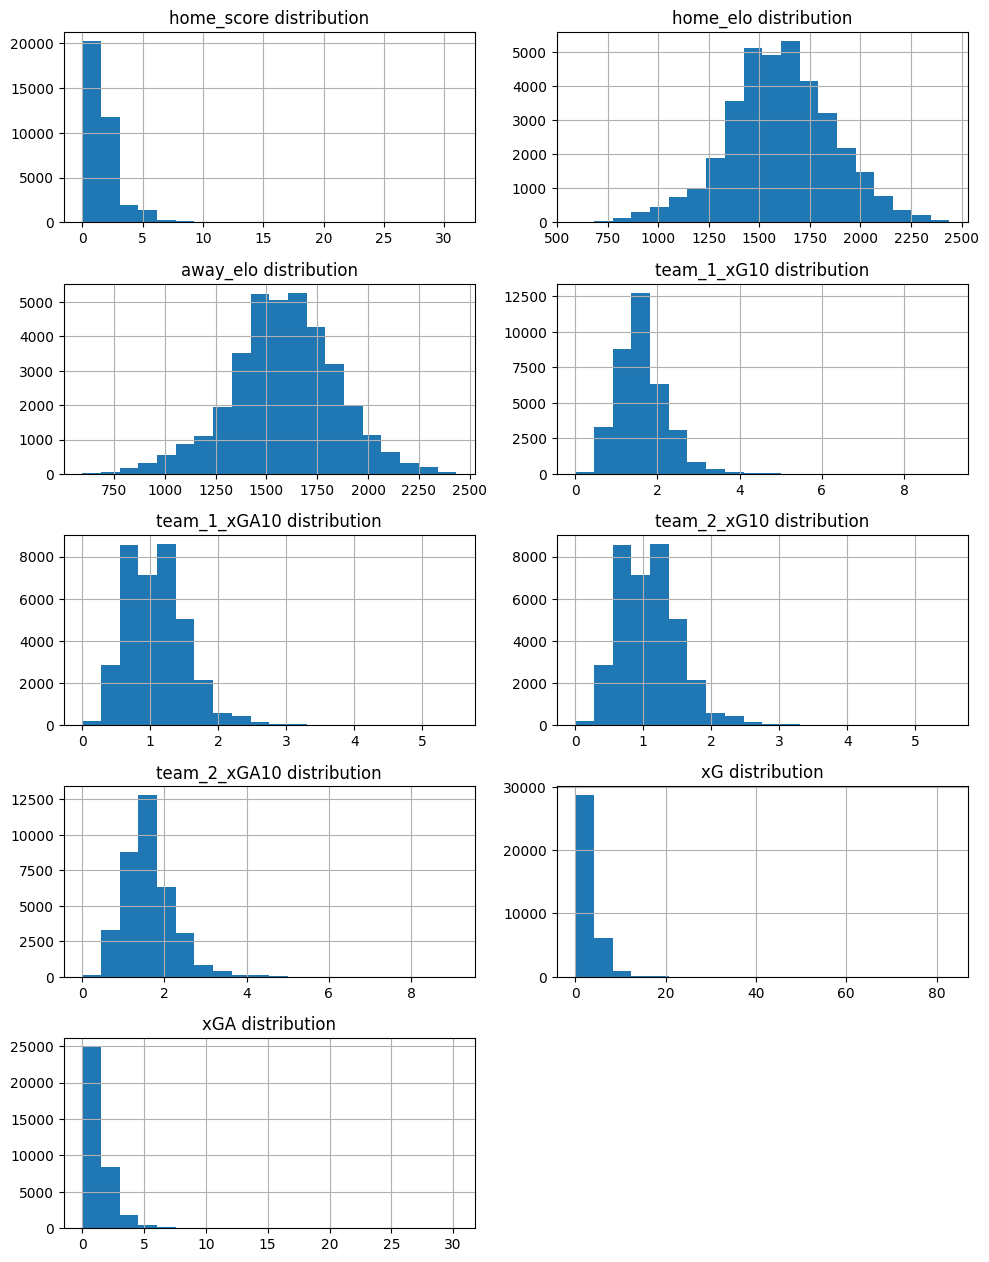

In [142]:
cols = list(df_final.columns)

plot_histograms(df_final,cols)

In [143]:
zeros_list = ['team_1_xG10', 'team_1_xGA10', 'team_2_xG10', 'team_2_xGA10', 'xG', 'xGA']

In [144]:
#df_ohe['Baseline (SU)'] = np.log(df_ohe['Baseline (SU)'])
df_final[zeros_list] += 0.01

C:\Users\niabrown\AppData\Local\Temp\ipykernel_27720\2934247592.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[zeros_list] += 0.01


In [145]:
df_final[zeros_list] = np.log(df_final[zeros_list])

C:\Users\niabrown\AppData\Local\Temp\ipykernel_27720\1144722461.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[zeros_list] = np.log(df_final[zeros_list])


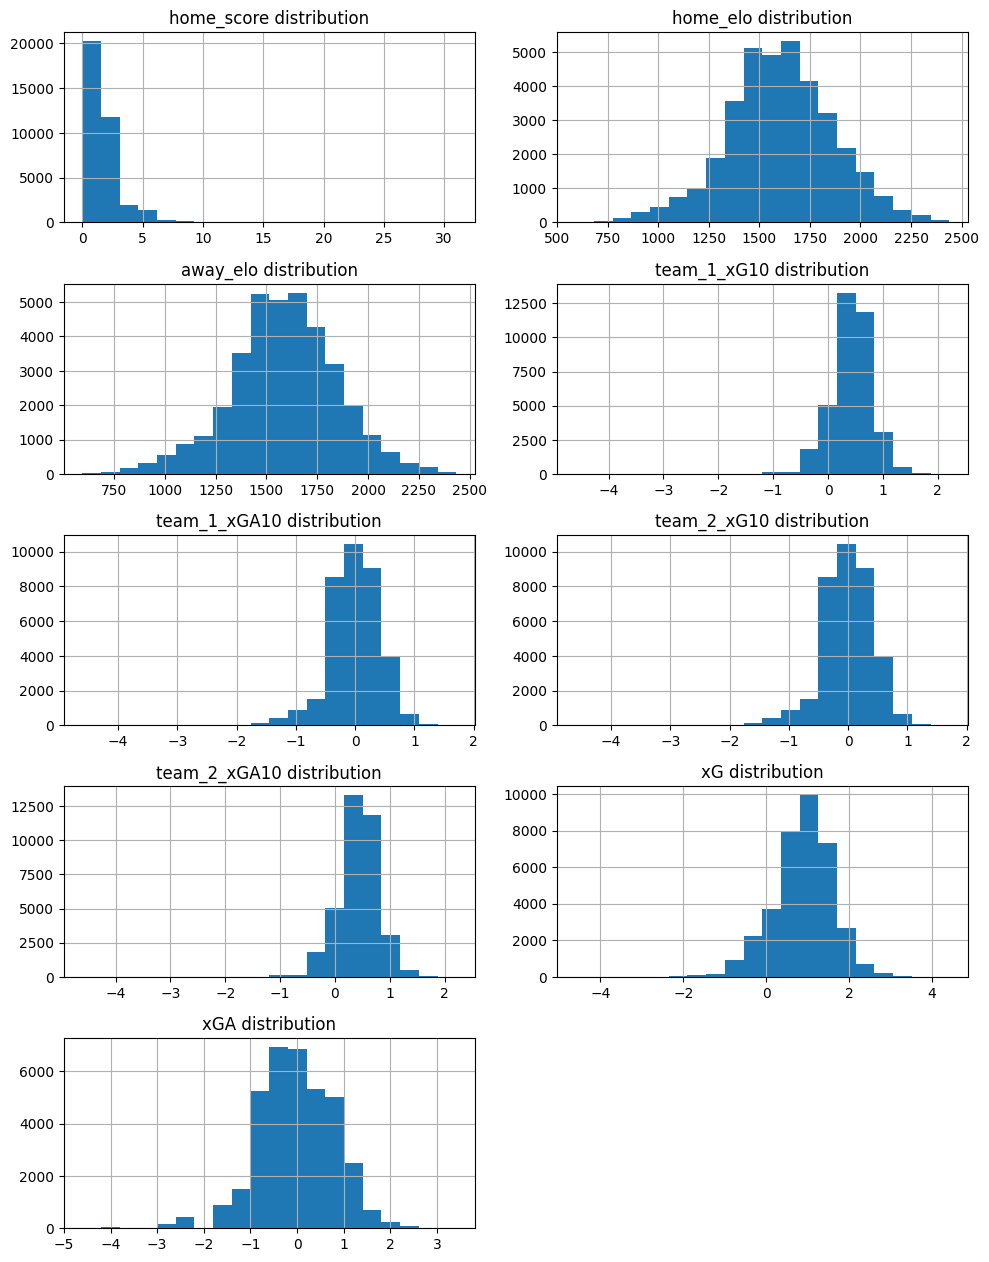

In [146]:
plot_histograms(df_final,cols)

In [154]:
from sklearn.model_selection import train_test_split
X = df_final.drop('home_score',axis = 1)
y = df_final['home_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle= True, random_state=10)

from sklearn.linear_model import PoissonRegressor
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.preprocessing import RobustScaler

pipeline = Pipeline([('model', PoissonRegressor(alpha = 0.01))])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
r2_test = metrics.r2_score(y_test, y_pred)

r2_test

0.2682670280727073

In [155]:
gd1_results = pipeline.predict(to_predict)

In [156]:
gd1_results

array([1.26511444, 0.97485481, 1.59493853, 1.80090428, 2.92703402,
       1.52382669, 2.18696278, 1.55353098, 1.82897199])